In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# Copy the dataset from drive to this colab notebook.
!cp "/content/drive/MyDrive/fer2013.tar.gz" "/content"

In [3]:
# Un-mount the google drive
drive.flush_and_unmount()

In [6]:
#  extract the files from the tar archiver
!tar -xvf  '/content/fer2013.tar.gz'

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [7]:
import os
import cv2
import dlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf

import keras
from keras.utils import to_categorical
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.callbacks import  Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Check TensorFlow and Keras versions
tensorflow_version = tf.__version__
keras_version = keras.__version__

print(f"Tensorflow Version : {tensorflow_version}")
print(f"Keras Version : {keras_version}")

Tensorflow Version : 2.17.0
Keras Version : 3.4.1


In [9]:
df = pd.read_csv('/content/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [10]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [11]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [12]:
df.emotion.value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


In [13]:
# Pick 3 with highest number of samples
INTERESTED_LABELS = [3, 4, 6]
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

In [14]:
# Convert the pixels data to images.
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [15]:
img_array.shape

(21264, 48, 48, 1)

In [16]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [17]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [18]:
# Split into train 90% , valid 10% sets.
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [19]:
# Remove unused variables.
del df
del img_array
del img_labels

In [20]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [21]:
# Normalizing results, as neural networks are very sensitive to non normalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [22]:
def ImageCNN(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [23]:
# The EarlyStopping callback in Keras is used to stop training when a monitored metric has stopped improving.
# This is useful to prevent overfitting and to save training time by stopping the training process when further training is unlikely to improve the model.
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

# The ReduceLROnPlateau callback in Keras is used to reduce the learning rate when a monitored metric has stopped improving.
# This can help the model converge more efficiently by allowing it to continue training with a smaller learning rate when progress slows down.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [24]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

In [25]:
train_datagen.fit(X_train)

In [26]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
model = ImageCNN(optimizers.Adam(0.001))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_2 (BatchNormalization)     │ (None, 48, 48, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_1 (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_3 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_4 (BatchNormalization)     │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_2 (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_5 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_6 (BatchNormalization)     │ (None, 12, 12, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ maxpool2d_3 (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batchnorm_7 (BatchNormalization)     │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,395,075 (9.14 MB)

 Trainable params: 2,393,027 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [27]:
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=int(len(X_train) / batch_size),
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


598/598 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.3861 - loss: 1.5109 - val_accuracy: 0.5378 - val_loss: 0.9669 - learning_rate: 0.0010
Epoch 2/100
  1/598 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.4688 - loss: 0.9803

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4688 - loss: 0.9803 - val_accuracy: 0.5388 - val_loss: 0.9665 - learning_rate: 0.0010
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.4695 - loss: 1.0386 - val_accuracy: 0.5820 - val_loss: 0.8849 - learning_rate: 0.0010
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5000 - loss: 1.0057 - val_accuracy: 0.5816 - val_loss: 0.8865 - learning_rate: 0.0010
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.5336 - loss: 0.9587 - val_accuracy: 0.6328 - val_loss: 0.7511 - learning_rate: 0.0010
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4688 - loss: 0.8902 - val_accuracy: 0.6385 - val_loss: 0.7522 - learning_rate: 0.0010
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.6056 - loss: 0.8234 - val_accuracy: 0.6690 - val_loss: 0.7408 - learning_rate: 0.0010
Epoch 8/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7188 - loss: 0.6838 -

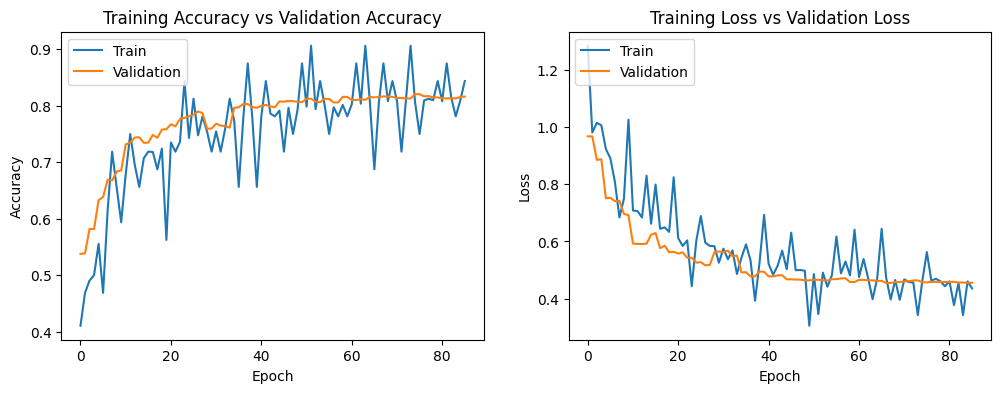

In [28]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


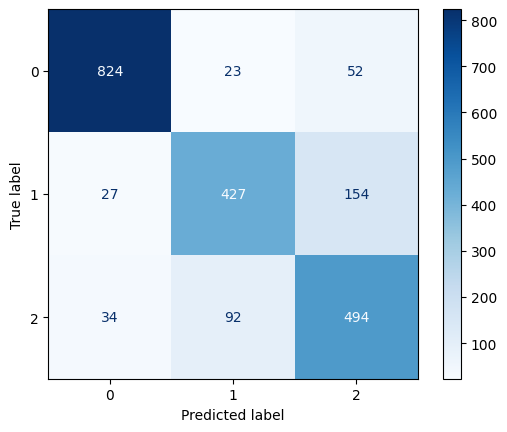

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes for the test data
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [30]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.45705944299697876
Test Accuracy: 0.8204043507575989


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


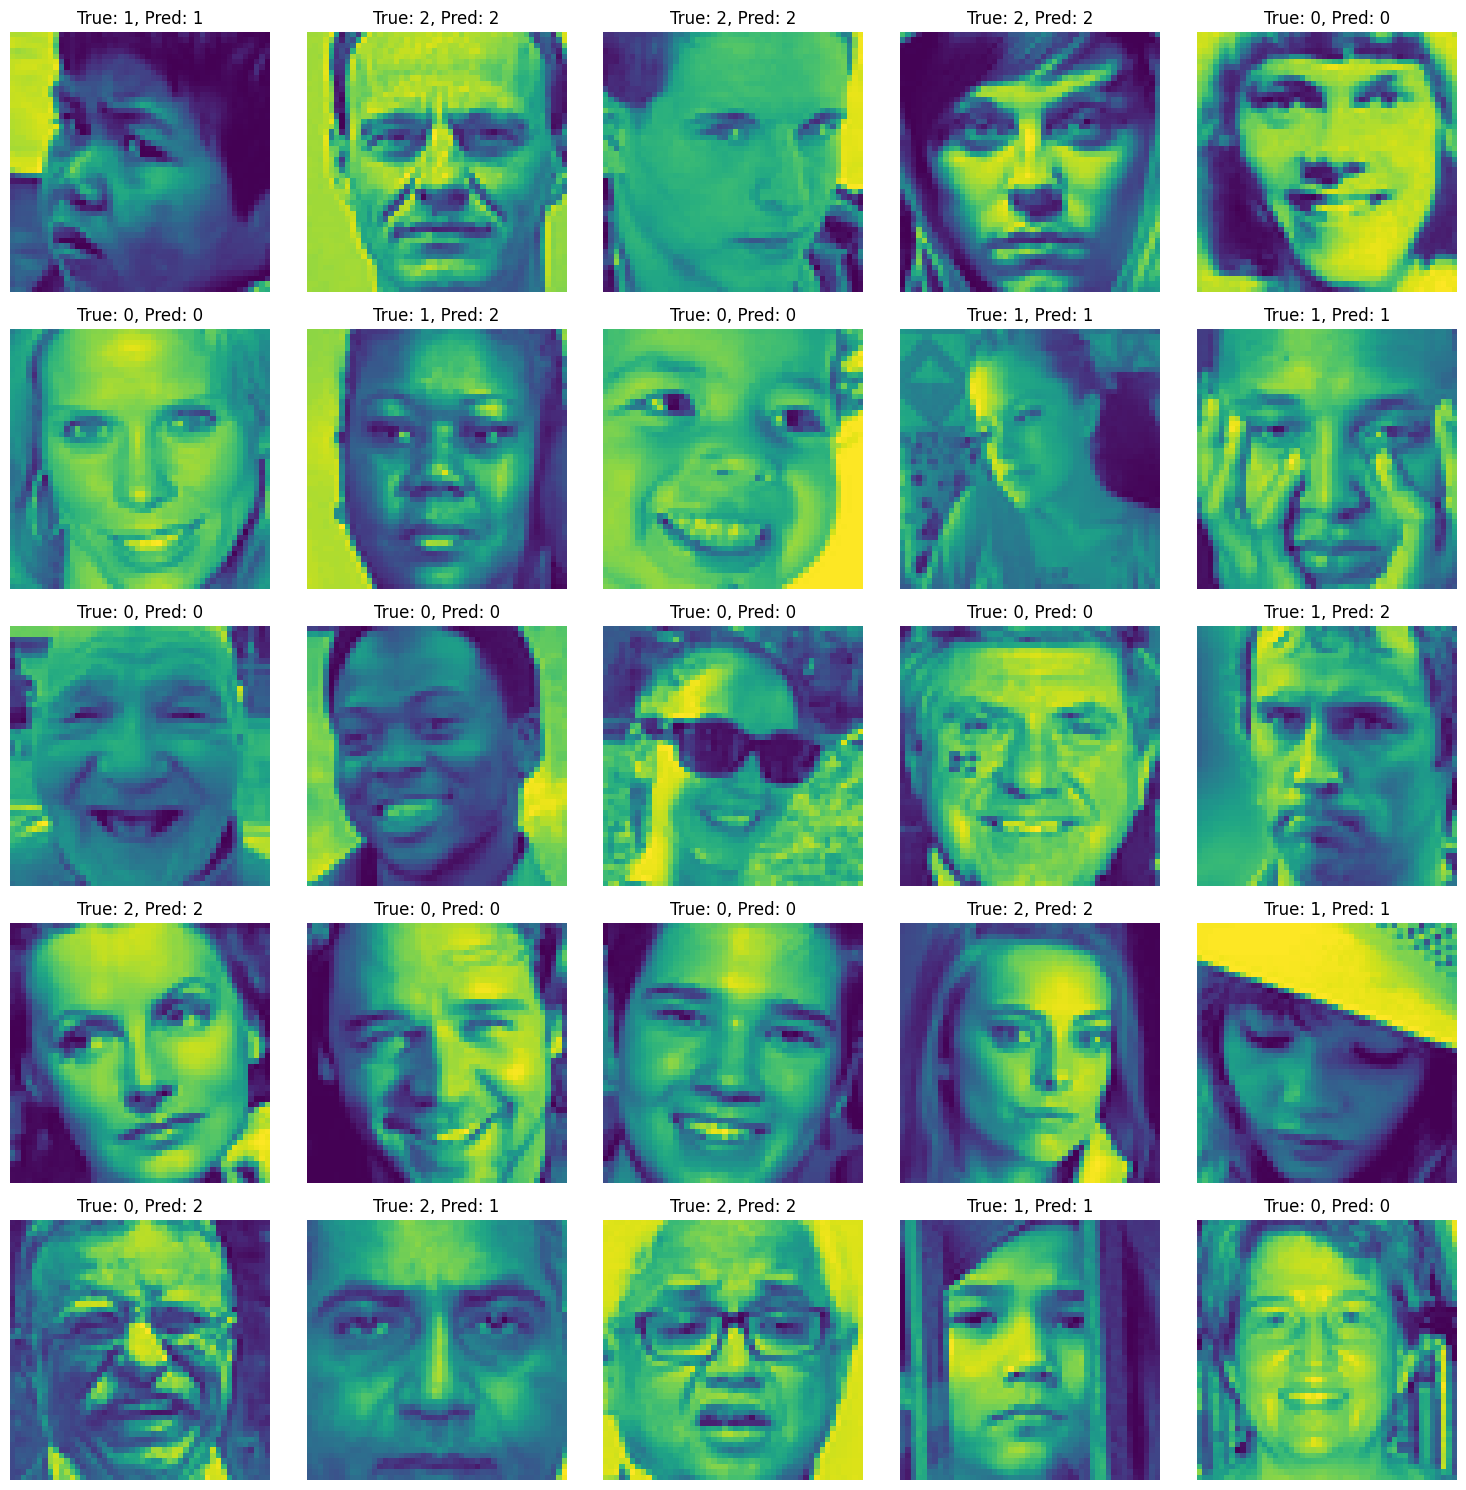

In [35]:
# Make predictions on the validation set
predictions = model.predict(X_valid)

# Get the predicted and true classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_valid, axis=1)  # If y_val is one-hot encoded

# Plot the images with their true and predicted labels
num_images = 25  # Number of images to display
plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(5, 5, i + 1)  # Create a grid for displaying images
    plt.imshow(X_valid[i])      # Display the image
    plt.title(f"True: {true_classes[i]}, Pred: {predicted_classes[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [36]:
model.save('model_optimal.keras')